In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from google.colab import files

In [52]:
data = pd.read_csv('/content/network_traffic_collected.csv')
data = pd.DataFrame(data)
data.head(5)

<ipython-input-52-c89012eb7dc8>:1: DtypeWarning: Columns (4,5,21) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/network_traffic_collected.csv')


,time,src_ip,dst_ip,protocol,packet_length,tcp_src_port,tcp_dst_port,udp_src_port,udp_dst_port,ttl,...,dns_resp_name,icmp_type,icmp_code,http_method,ssl_handshake_type,ip_flags,ack_rtt,retransmission,lost_segment,time_delta
0,1.730985e+09,172.17.18.80,224.0.0.251,MDNS,103,NaN,NaN,5353.0,5353.0,255.0,...,_googlecast._tcp.local,NaN,NaN,NaN,NaN,NaN,0x02,NaN,NaN,NaN
1,1.730985e+09,0.0.0.0,255.255.255.255,DHCP,348,NaN,NaN,68.0,67.0,64.0,...,NaN,NaN,NaN,NaN,NaN,0x02,NaN,NaN,NaN,0.369502000
2,1.730985e+09,172.17.16.1,255.255.255.255,DHCP,345,NaN,NaN,67.0,68.0,128.0,...,NaN,NaN,NaN,NaN,NaN,0x00,NaN,NaN,NaN,0.000000000
3,1.730985e+09,172.17.17.67,239.255.255.250,SSDP,179,NaN,NaN,53962.0,1900.0,4.0,...,NaN,NaN,NaN,M-SEARCH,NaN,0x00,NaN,NaN,NaN,0.015783000
4,1.730985e+09,0.0.0.0,255.255.255.255,DHCP,344,NaN,NaN,68.0,67.0,64.0,...,NaN,NaN,NaN,NaN,NaN,0x02,NaN,NaN,NaN,0.002920000


In [53]:
print(data.info())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   time                100000 non-null  float64
 1   src_ip              97129 non-null   object 
 2   dst_ip              97129 non-null   object 
 3   protocol            100000 non-null  object 
 4   packet_length       100000 non-null  object 
 5   tcp_src_port        95546 non-null   object 
 6   tcp_dst_port        95546 non-null   float64
 7   udp_src_port        2046 non-null    float64
 8   udp_dst_port        2046 non-null    float64
 9   ttl                 97129 non-null   float64
 10  tcp_flags           95546 non-null   object 
 11  window_size         95546 non-null   float64
 12  dns_qry_name        947 non-null     object 
 13  dns_resp_name       779 non-null     object 
 14  icmp_type           692 non-null     object 
 15  icmp_code           594 non-null   

# **Removing the Unwanted Columns**

In [54]:
data = data.drop(columns=['dns_qry_name', 'lost_segment','dns_resp_name','icmp_code','icmp_type','http_method','ssl_handshake_type','udp_src_port','udp_dst_port','ip_flags'])

In [55]:
data.columns

Index(['time', 'src_ip', 'dst_ip', 'protocol', 'packet_length', 'tcp_src_port',
       'tcp_dst_port', 'ttl', 'tcp_flags', 'window_size', 'ack_rtt',
       'retransmission', 'time_delta'],
      dtype='object')

# **Type Casting the Columns to the Numeric**

In [56]:
data = data.dropna(subset=['src_ip', 'dst_ip'])
data['ack_rtt'] = pd.to_numeric(data['ack_rtt'], errors='coerce')
data['ttl'] = pd.to_numeric(data['ttl'], errors='coerce')
data['tcp_src_port'] = pd.to_numeric(data['tcp_src_port'], errors='coerce')
data['tcp_dst_port'] = pd.to_numeric(data['tcp_dst_port'], errors='coerce')
data['window_size'] = pd.to_numeric(data['window_size'], errors='coerce')
data['time_delta'] = pd.to_numeric(data['time_delta'], errors='coerce')
data['packet_length'] = pd.to_numeric(data['packet_length'], errors='coerce')
data['retransmission'] = pd.to_numeric(data['retransmission'], errors='coerce')
data['retransmission'] = data['retransmission'].notnull().astype(int)

<ipython-input-56-c996b19184ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ack_rtt'] = pd.to_numeric(data['ack_rtt'], errors='coerce')
<ipython-input-56-c996b19184ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ttl'] = pd.to_numeric(data['ttl'], errors='coerce')
<ipython-input-56-c996b19184ad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [57]:
data['tcp_flags'] = data['tcp_flags'].apply(lambda x: int(x, 16) if isinstance(x, str) else x)


# **IP Address Problem Resolving**

In [58]:
data = data[(data['src_ip'] != 0) & (data['dst_ip'] != 0)].dropna(subset=['src_ip', 'dst_ip']).reset_index(drop=True)

import ipaddress

def ip_to_int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return np.nan

data['src_ip'] = data['src_ip'].apply(ip_to_int)
data['dst_ip'] = data['dst_ip'].apply(ip_to_int)

# **Imputation techniques**

In [59]:
# MODE IMPUTATION

mode_imputer = SimpleImputer(strategy='most_frequent')
data[['tcp_src_port', 'tcp_dst_port', 'window_size']] = mode_imputer.fit_transform(
    data[['tcp_src_port', 'tcp_dst_port', 'window_size']]
)


In [60]:
#MEDIAN IMPUTATION

median_imputer = SimpleImputer(strategy='median')
data[['ack_rtt', 'ttl']] = median_imputer.fit_transform(data[['ack_rtt', 'ttl']])

data['packet_length'].fillna(data['packet_length'].median(), inplace=True)
data['tcp_flags'].fillna(data['tcp_flags'].median(), inplace=True)
data['time_delta'].fillna(data['time_delta'].median(), inplace=True)

<ipython-input-60-39bb4717e31d>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['packet_length'].fillna(data['packet_length'].median(), inplace=True)
<ipython-input-60-39bb4717e31d>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value

# **FEATURE ENGINEERING**

In [61]:
data.columns

Index(['time', 'src_ip', 'dst_ip', 'protocol', 'packet_length', 'tcp_src_port',
       'tcp_dst_port', 'ttl', 'tcp_flags', 'window_size', 'ack_rtt',
       'retransmission', 'time_delta'],
      dtype='object')

In [62]:
avg_latency = data.groupby(['src_ip', 'dst_ip'])['time_delta'].mean().rename("avg_latency")
jitter = data.groupby(['src_ip', 'dst_ip'])['time_delta'].std().rename("jitter")
total_data = data.groupby(['src_ip', 'dst_ip'])['packet_length'].sum().rename("total_data")
session_duration = data.groupby(['src_ip', 'dst_ip'])['time'].apply(lambda x: x.max() - x.min()).rename("session_duration")

session_duration = session_duration.replace({0: 0.001})
bandwidth = ((total_data * 8) / session_duration / 1e6).fillna(0.).rename("bandwidth")

In [63]:
metrics = pd.concat([avg_latency, jitter, total_data, session_duration, bandwidth], axis=1).reset_index()


data = data.merge(metrics, on=['src_ip', 'dst_ip'], how='left')


data['avg_latency_ms'] = (data['avg_latency'] * 1000).round(2)           # Convert seconds to ms
data['jitter_ms'] = (data['jitter'] * 1000).round(2)                     # Convert seconds to ms
data['total_data_mb'] = (data['total_data'] / (1024 * 1024)).round(2)    # Convert bytes to MB
data['session_duration_sec'] = data['session_duration'].round(2)         # Seconds
data['bandwidth_mbps'] = data['bandwidth'].round(2)                      # Mbps

data = data.dropna(subset=["bandwidth"])

In [64]:
data

,time,src_ip,dst_ip,protocol,packet_length,tcp_src_port,tcp_dst_port,ttl,tcp_flags,window_size,...,avg_latency,jitter,total_data,session_duration,bandwidth,avg_latency_ms,jitter_ms,total_data_mb,session_duration_sec,bandwidth_mbps
0,1.730985e+09,2886799952,3758096635,MDNS,103.0,443.0,443.0,255.0,16.0,315.0,...,0.000000,0.000000,2472.0,460.074581,0.000043,0.00,0.00,0.00,460.07,0.00
1,1.730985e+09,0,4294967295,DHCP,348.0,443.0,443.0,64.0,16.0,315.0,...,0.069101,0.099934,21212.0,457.430387,0.000371,69.10,99.93,0.02,457.43,0.00
2,1.730985e+09,2886799361,4294967295,DHCP,345.0,443.0,443.0,128.0,16.0,315.0,...,0.000000,NaN,345.0,0.001000,2.760000,0.00,NaN,0.00,0.00,2.76
3,1.730985e+09,2886799683,4026531834,SSDP,179.0,443.0,443.0,4.0,16.0,315.0,...,0.082102,0.099248,3651.0,449.541159,0.000065,82.10,99.25,0.00,449.54,0.00
4,1.730985e+09,0,4294967295,DHCP,344.0,443.0,443.0,64.0,16.0,315.0,...,0.069101,0.099934,21212.0,457.430387,0.000371,69.10,99.93,0.02,457.43,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97124,1.730986e+09,2889915345,2886800497,TLSv1.3,964.0,443.0,50145.0,59.0,24.0,10.0,...,0.005957,0.020786,100496.0,5.672080,0.141741,5.96,20.79,0.10,5.67,0.14
97125,1.730986e+09,2889915345,2886800497,TLSv1.3,101.0,443.0,50145.0,59.0,24.0,10.0,...,0.005957,0.020786,100496.0,5.672080,0.141741,5.96,20.79,0.10,5.67,0.14
97126,1.730986e+09,2889915345,2886800497,TLSv1.3,85.0,443.0,50145.0,59.0,24.0,10.0,...,0.005957,0.020786,100496.0,5.672080,0.141741,5.96,20.79,0.10,5.67,0.14
97127,1.730986e+09,2886800497,2889915345,TCP,54.0,50145.0,443.0,128.0,16.0,510.0,...,0.004569,0.014777,279200.0,5.693556,0.392303,4.57,14.78,0.27,5.69,0.39


# **VISUALIZATION AND EDA**

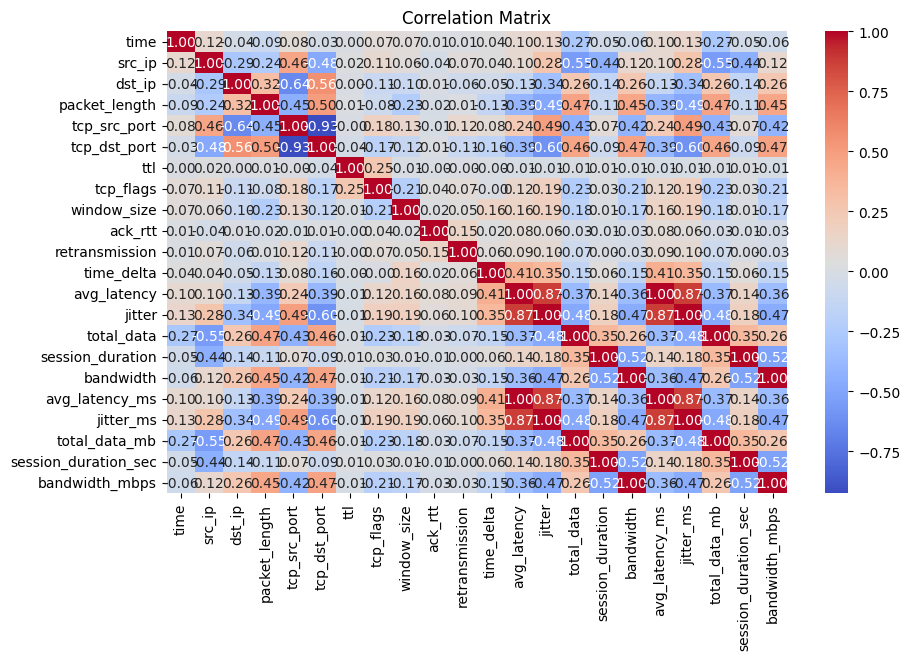

In [65]:
numerical_data = data.select_dtypes(include=['number'])


corr_matrix = numerical_data.corr()


plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

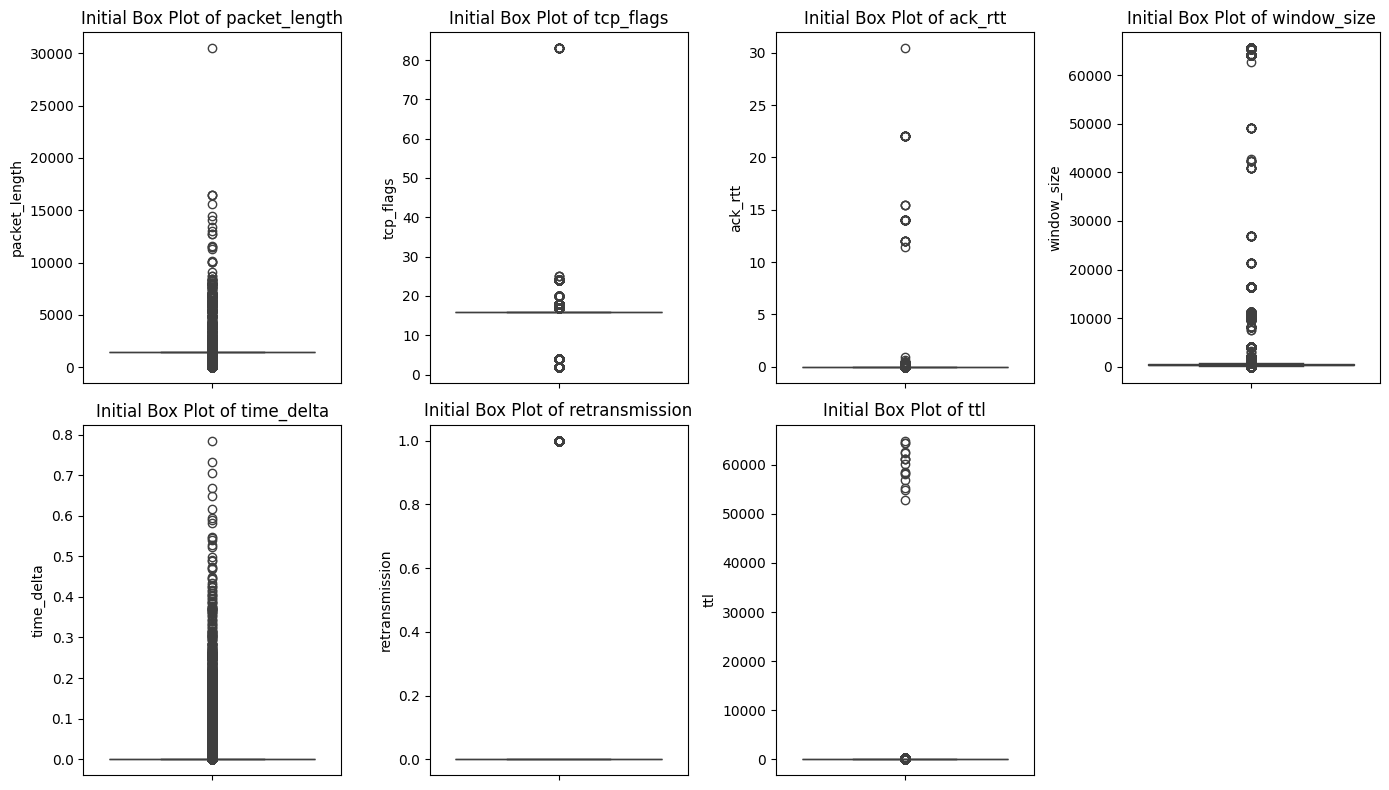

In [66]:
corr_features = ['packet_length', 'tcp_flags', 'ack_rtt', 'window_size', 'time_delta', 'retransmission', 'ttl']

plt.figure(figsize=(14, 8))
for i, feature in enumerate(corr_features, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(data[feature])
    plt.title(f'Initial Box Plot of {feature}')
plt.tight_layout()
plt.show()

In [67]:
from scipy.stats import zscore

corr_features2 = ['packet_length', 'tcp_flags', 'ack_rtt', 'window_size', 'time_delta', 'ttl']
z_scores = np.abs(zscore(data[corr_features2]))
data = data[(z_scores < 3).all(axis=1)]

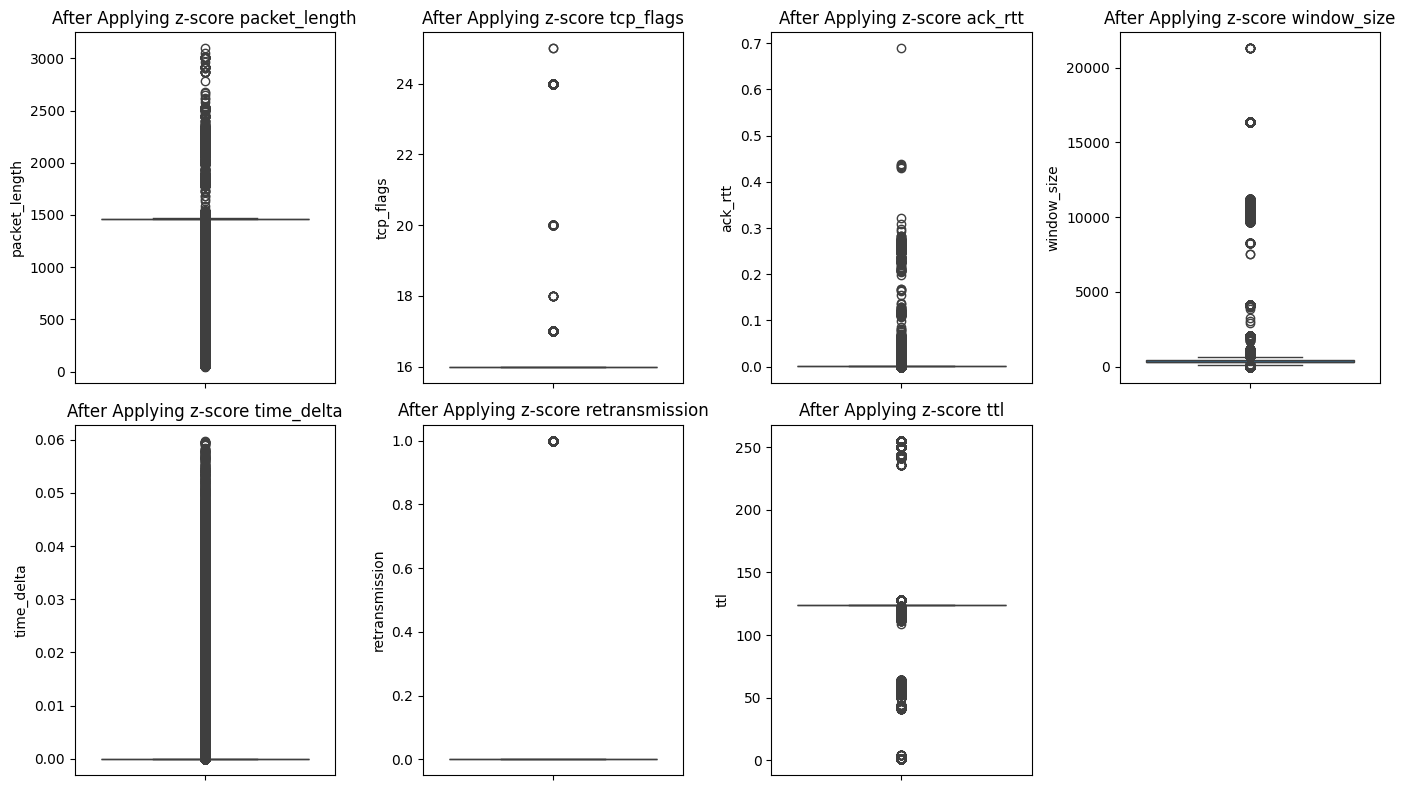

In [68]:
plt.figure(figsize=(14, 8))
for i, feature in enumerate(corr_features, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(data[feature])
    plt.title(f'After Applying z-score {feature}')
plt.tight_layout()
plt.show()

<ipython-input-70-26b220591724>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[corr_features2] = scaler.fit_transform(data[corr_features2])


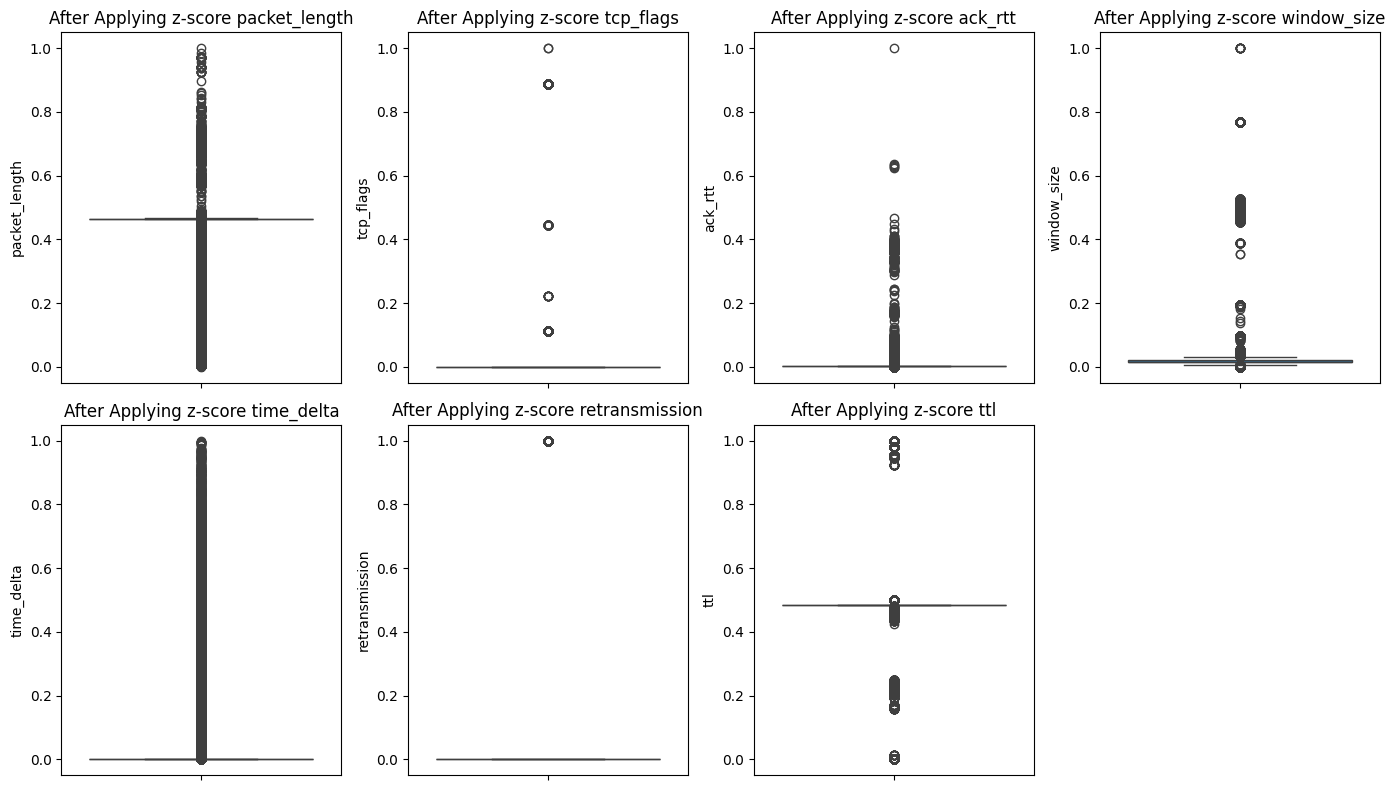

In [70]:
scaler = MinMaxScaler()


data[corr_features2] = scaler.fit_transform(data[corr_features2])

plt.figure(figsize=(14, 8))
for i, feature in enumerate(corr_features, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(data[feature])
    plt.title(f'After Applying z-score {feature}')
plt.tight_layout()
plt.show()

In [71]:
data

,time,src_ip,dst_ip,protocol,packet_length,tcp_src_port,tcp_dst_port,ttl,tcp_flags,window_size,...,avg_latency,jitter,total_data,session_duration,bandwidth,avg_latency_ms,jitter_ms,total_data_mb,session_duration_sec,bandwidth_mbps
0,1.730985e+09,2886799952,3758096635,MDNS,0.018367,443.0,443.0,1.000000,0.000000,0.014789,...,0.000000,0.000000,2472.0,460.074581,0.000043,0.00,0.00,0.00,460.07,0.00
2,1.730985e+09,2886799361,4294967295,DHCP,0.097737,443.0,443.0,0.500000,0.000000,0.014789,...,0.000000,NaN,345.0,0.001000,2.760000,0.00,NaN,0.00,0.00,2.76
3,1.730985e+09,2886799683,4026531834,SSDP,0.043293,443.0,443.0,0.011811,0.000000,0.014789,...,0.082102,0.099248,3651.0,449.541159,0.000065,82.10,99.25,0.00,449.54,0.00
4,1.730985e+09,0,4294967295,DHCP,0.097409,443.0,443.0,0.248031,0.000000,0.014789,...,0.069101,0.099934,21212.0,457.430387,0.000371,69.10,99.93,0.02,457.43,0.00
5,1.730985e+09,0,4294967295,DHCP,0.100689,443.0,443.0,0.248031,0.000000,0.014789,...,0.069101,0.099934,21212.0,457.430387,0.000371,69.10,99.93,0.02,457.43,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97124,1.730986e+09,2889915345,2886800497,TLSv1.3,0.300754,443.0,50145.0,0.228346,0.888889,0.000469,...,0.005957,0.020786,100496.0,5.672080,0.141741,5.96,20.79,0.10,5.67,0.14
97125,1.730986e+09,2889915345,2886800497,TLSv1.3,0.017711,443.0,50145.0,0.228346,0.888889,0.000469,...,0.005957,0.020786,100496.0,5.672080,0.141741,5.96,20.79,0.10,5.67,0.14
97126,1.730986e+09,2889915345,2886800497,TLSv1.3,0.012463,443.0,50145.0,0.228346,0.888889,0.000469,...,0.005957,0.020786,100496.0,5.672080,0.141741,5.96,20.79,0.10,5.67,0.14
97127,1.730986e+09,2886800497,2889915345,TCP,0.002296,50145.0,443.0,0.500000,0.000000,0.023944,...,0.004569,0.014777,279200.0,5.693556,0.392303,4.57,14.78,0.27,5.69,0.39


In [72]:
unique_values = data['bandwidth_mbps'].unique()
print(f"Unique tcp_flags values: {unique_values}")

Unique tcp_flags values: [0.   2.76 0.43 0.01 0.03 0.07 0.02 1.34 0.06 0.16 0.32 0.61 2.3  2.21
 0.08 0.58 0.24 0.04 2.05 4.15 0.68 3.15 0.14 0.09 1.35 0.05 0.39]


In [75]:
data.columns

Index(['time', 'src_ip', 'dst_ip', 'protocol', 'packet_length', 'tcp_src_port',
       'tcp_dst_port', 'ttl', 'tcp_flags', 'window_size', 'ack_rtt',
       'retransmission', 'time_delta', 'avg_latency', 'jitter', 'total_data',
       'session_duration', 'bandwidth', 'avg_latency_ms', 'jitter_ms',
       'total_data_mb', 'session_duration_sec', 'bandwidth_mbps'],
      dtype='object')

In [74]:
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
# Perform ANOVA test on 'packet_length' for different 'protocol' categories

df = data.copy()
anova_result = stats.f_oneway(
    *[group['packet_length'] for name, group in df.groupby('protocol')]
)

print(f"ANOVA result for packet_length across protocols: F-statistic = {anova_result.statistic}, p-value = {anova_result.pvalue}")


ANOVA result for packet_length across protocols: F-statistic = 667.796611928165, p-value = 0.0


In [76]:
from scipy.stats import f_oneway

df = data.copy()
columns_to_test = [
    'time', 'src_ip', 'dst_ip', 'protocol', 'tcp_src_port', 'tcp_dst_port',
    'ttl', 'tcp_flags', 'window_size', 'ack_rtt', 'retransmission',
    'time_delta', 'avg_latency', 'jitter', 'total_data', 'session_duration',
    'bandwidth', 'avg_latency_ms', 'jitter_ms', 'total_data_mb',
    'session_duration_sec', 'bandwidth_mbps'
]


anova_results = {}

for column in columns_to_test:
    try:

        groups = [group['packet_length'] for _, group in df.groupby(column)]
        result = f_oneway(*groups)
        anova_results[column] = (result.statistic, result.pvalue)
    except Exception as e:

        anova_results[column] = f"Error: {e}"


for column, result in anova_results.items():
    print(f"ANOVA test for 'packet_length' with '{column}': {result}")


ANOVA test for 'packet_length' with 'time': (73.0399655816593, 0.0)
ANOVA test for 'packet_length' with 'src_ip': (1549.3354256342416, 0.0)
ANOVA test for 'packet_length' with 'dst_ip': (503.3447832975091, 0.0)
ANOVA test for 'packet_length' with 'protocol': (667.796611928165, 0.0)
ANOVA test for 'packet_length' with 'tcp_src_port': (96.07692814229031, 0.0)
ANOVA test for 'packet_length' with 'tcp_dst_port': (418.4701157954675, 0.0)
ANOVA test for 'packet_length' with 'ttl': (4199.792894968823, 0.0)
ANOVA test for 'packet_length' with 'tcp_flags': (2469.5629442216905, 0.0)
ANOVA test for 'packet_length' with 'window_size': (254.74002657510056, 0.0)
ANOVA test for 'packet_length' with 'ack_rtt': (17.01713189782257, 0.0)
ANOVA test for 'packet_length' with 'retransmission': (75.78527272316441, 3.212153478192811e-18)
ANOVA test for 'packet_length' with 'time_delta': (15.559080911161248, 0.0)
ANOVA test for 'packet_length' with 'avg_latency': (829.2033523782525, 0.0)
ANOVA test for 'packet

---

From this , We can infer that the all the parameters that have some



slighter changes depends on packet length

---



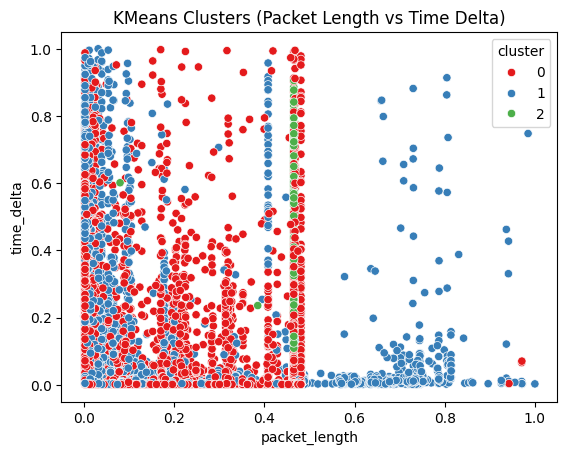

In [77]:

features = df[['packet_length', 'tcp_src_port', 'tcp_dst_port', 'ttl', 'window_size',
               'ack_rtt', 'retransmission', 'time_delta']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=0)
df['cluster'] = kmeans.fit_predict(scaled_features)


sns.scatterplot(x=df['packet_length'], y=df['time_delta'], hue=df['cluster'], palette="Set1")
plt.title("KMeans Clusters (Packet Length vs Time Delta)")
plt.show()


In [84]:
data = data.drop(columns=['anomaly_score', 'anomaly_category'])

In [94]:
from sklearn.ensemble import IsolationForest
import pandas as pd
import numpy as np


X_spikes = data[['packet_length', 'ack_rtt', 'time_delta', 'ttl', 'retransmission', 'window_size']]


iso_forest = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)


iso_forest.fit(X_spikes)


data['anomaly_score'] = iso_forest.decision_function(X_spikes)


threshold_danger = np.percentile(data['anomaly_score'], 1)
threshold_critical = np.percentile(data['anomaly_score'], 2) # Lower percentile for "Critical"

# Categorize data based on the adjusted anomaly score thresholds
def categorize_anomaly(score):
    if score <= threshold_danger:
        return 'Danger'
    elif score <= threshold_critical:
        return 'Critical'
    else:
        return 'Normal'

data['anomaly_category'] = data['anomaly_score'].apply(categorize_anomaly)

# View the results
print(data[['packet_length', 'ack_rtt', 'time_delta', 'ttl', 'retransmission', 'window_size',
            'anomaly_score', 'anomaly_category']].head())


   packet_length   ack_rtt  time_delta       ttl  retransmission  window_size  \
0       0.018367  0.001196    0.001086  1.000000               0     0.014789   
2       0.097737  0.001196    0.001086  0.500000               0     0.014789   
3       0.043293  0.001196    0.264773  0.011811               0     0.014789   
4       0.097409  0.001196    0.049871  0.248031               0     0.014789   
5       0.100689  0.001196    0.059761  0.248031               0     0.014789   

   anomaly_score anomaly_category  
0       0.132634           Normal  
2       0.276622           Normal  
3       0.064402           Normal  
4       0.173544           Normal  
5       0.165858           Normal  


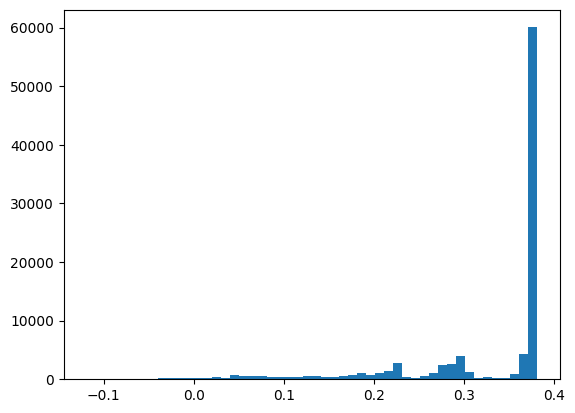

In [95]:
import matplotlib.pyplot as plt
plt.hist(data['anomaly_score'], bins=50)
plt.show()

In [97]:
import joblib


model_filename = 'isolation_forest_model.pkl'
joblib.dump(iso_forest, model_filename)

files.download(model_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

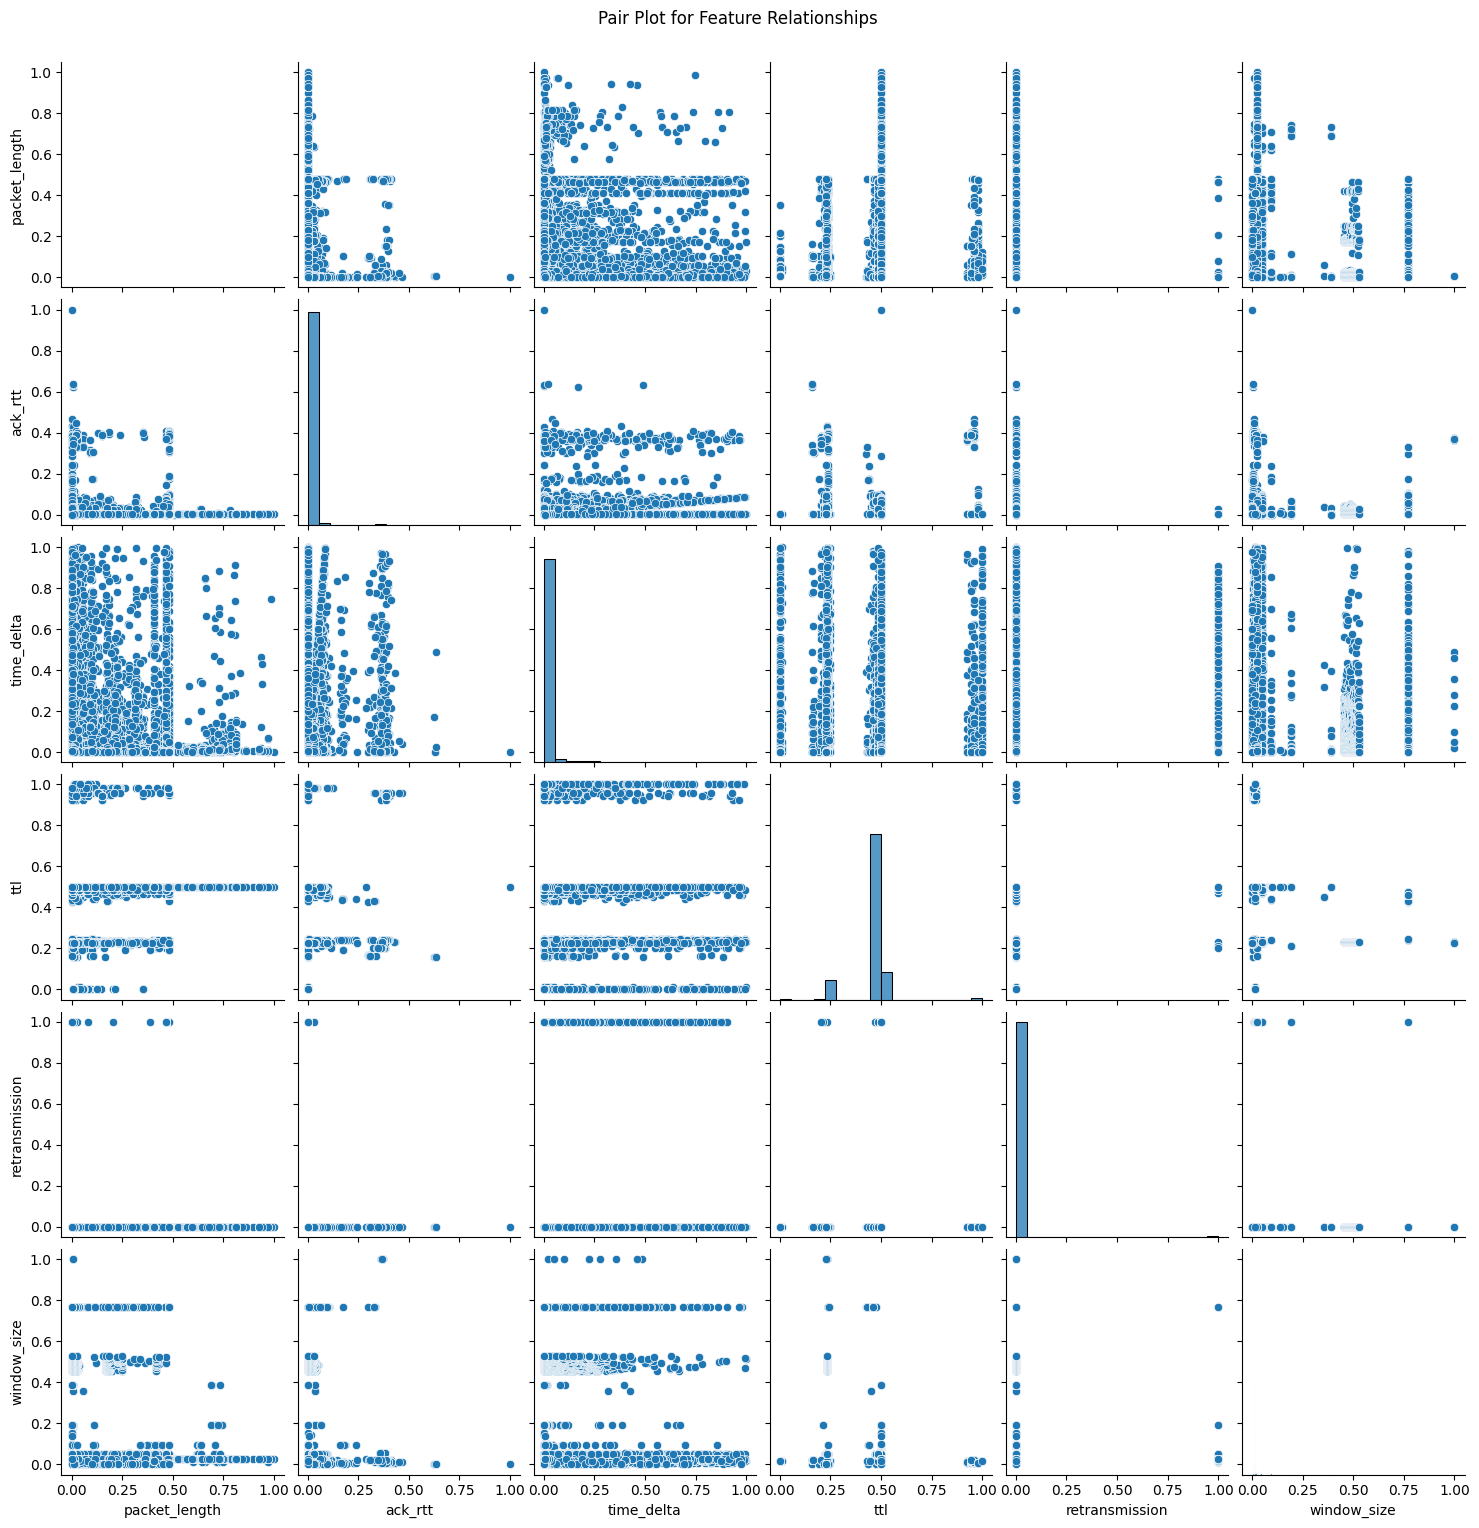

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizing the relationships between features using pairplot
sns.pairplot(data[['packet_length', 'ack_rtt', 'time_delta', 'ttl', 'retransmission', 'window_size']])
plt.suptitle('Pair Plot for Feature Relationships', y=1.02)
plt.show()


In [101]:
from sklearn.svm import OneClassSVM
import numpy as np
import pandas as pd

# Assuming data is your normal traffic data
X_spikes = data[['packet_length', 'ack_rtt', 'time_delta', 'ttl', 'retransmission', 'window_size']]

# Initialize One-Class SVM model
oc_svm = OneClassSVM(nu=0.01, kernel='rbf', gamma='auto')

# Train the model using only normal data
oc_svm.fit(X_spikes)

# Predict anomalies (1 for normal, -1 for anomaly)
data['anomaly_category'] = oc_svm.predict(X_spikes)

# Convert predictions: 1 -> Normal, -1 -> Anomaly (potential DDoS)
data['anomaly_category'] = data['anomaly_category'].apply(lambda x: 'Normal' if x == 1 else 'Anomaly')

# View the results
print(data[['packet_length', 'ack_rtt', 'time_delta', 'ttl', 'retransmission', 'anomaly_category']].head())


   packet_length   ack_rtt  time_delta       ttl  retransmission  \
0       0.018367  0.001196    0.001086  1.000000               0   
2       0.097737  0.001196    0.001086  0.500000               0   
3       0.043293  0.001196    0.264773  0.011811               0   
4       0.097409  0.001196    0.049871  0.248031               0   
5       0.100689  0.001196    0.059761  0.248031               0   

  anomaly_category  
0          Anomaly  
2           Normal  
3           Normal  
4           Normal  
5           Normal  


In [102]:
joblib.dump(oc_svm, '/content/oc_svm_model.pkl')

['/content/oc_svm_model.pkl']

In [103]:
import pickle

# Save the trained model (One-Class SVM)
with open('/content/oc_svm_model.pkl', 'wb') as f:
    pickle.dump(oc_svm, f)


files.download('/content/oc_svm_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>